In [40]:
# Load required libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dask.distributed import Client, LocalCluster
import pyproj
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import verde as vd
# Load our custom gridder and utility functions
from vectorspline3d import VectorSpline3D, VectorSpline3DCV
from vectorspline3d.utils import DummyGridder

In [2]:
client = Client(LocalCluster(n_workers=2, threads_per_worker=2))
client

Client Scheduler: tcp://127.0.0.1:33347 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.35 GB


In [3]:
data = pd.read_csv("../../data/tibet-gps.csv", na_values="-").dropna().reset_index(drop=True)
print(vd.get_region((data.longitude, data.latitude)))
data.up_velocity *= 1
data.describe()

(75.23, 109.82, 13.02, 47.87)


,longitude,latitude,north_velocity,north_velocity_std,east_velocity,east_velocity_std,up_velocity,up_velocity_std
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,99.575956,33.430244,0.644889,0.757444,6.648222,0.762489,1.418222,1.401422
std,6.943382,4.956728,10.143781,0.172611,5.222720,0.167667,1.537121,0.318298
min,75.230000,13.020000,-15.900000,0.160000,-7.400000,0.160000,-3.800000,0.510000
25%,98.025000,29.547500,-4.200000,0.700000,3.400000,0.710000,0.500000,1.190000
50%,101.630000,34.350000,-0.950000,0.720000,5.800000,0.720000,1.600000,1.490000
75%,104.050000,37.317500,2.500000,0.920000,8.875000,0.920000,2.500000,1.540000
max,109.820000,47.870000,37.900000,1.190000,26.700000,1.190000,4.900000,2.400000


In [4]:
region = (73, 112, 19, 46)
region = (95, 112, 19, 46)
data = data[vd.inside((data.longitude, data.latitude), region)]

coordinates = (data.longitude.values, data.latitude.values)
components = (data.east_velocity, data.north_velocity, data.up_velocity)
uncertainty = (data.east_velocity_std, data.north_velocity_std, data.up_velocity_std)
weights = tuple(w*vd.variance_to_weights(u**2) for w, u in zip([0.01, 0.01, 1], uncertainty))

ndata = data.shape[0]
print(ndata)
spacing = 0.25

projection = pyproj.Proj(proj="aea", lon_0=data.longitude.mean())
proj_coords = projection(*coordinates)

363


In [5]:
def plot_data(data, ax=None, maxabs=5, every_arrow=5, quiver_scale=200, quiver_width=0.0015, size=50):
    "Plot a grid or a DataFrame with the vertical in color and horizontal as vectors."
    crs = ccrs.Mercator()
    transform = ccrs.PlateCarree()
    if ax is None:
        plt.figure(figsize=(13, 16))
        ax = plt.subplot(111, projection=crs)
    #ax.add_feature(cfeature.GSHHSFeature(), facecolor="gray", zorder=-1)
    ax.add_feature(cfeature.LAND, facecolor="gray")
    #ax.stock_img()
    cbargs = dict(orientation="horizontal", aspect=50, label="vertical velocity (mm/yr)",
                  shrink=0.8, pad=0.05)
    if isinstance(data, pd.DataFrame):
        tmp = ax.scatter(
            data.longitude, data.latitude, s=size, c=data.up_velocity,
            vmin=-maxabs, vmax=maxabs, cmap="seismic", transform=transform
        )
        plt.colorbar(tmp, ax=ax, **cbargs)        
    else:
        data.up_velocity.plot.pcolormesh(
            ax=ax, vmin=-maxabs, vmax=maxabs, cmap="seismic", cbar_kwargs=cbargs, 
            add_labels=False, transform=transform
        )
        indexer = slice(None, None, every_arrow)
        # Downsample the arrows so we can actually see something
        data = data.isel(longitude=indexer, latitude=indexer)
    ax.quiver(data.longitude.values, data.latitude.values, 
              data.east_velocity.values, data.north_velocity.values, 
              scale=quiver_scale, width=quiver_width, transform=transform)
    #ax.coastlines(resolution="50m", linewidth=1)
    # Set the proper ticks for a Cartopy map
    ax.set_xticks(np.arange(*region[:2], 3)[1:], crs=transform)
    ax.set_yticks(np.arange(*region[2:], 3)[1:], crs=transform)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_extent(region, crs=transform)    
    return ax

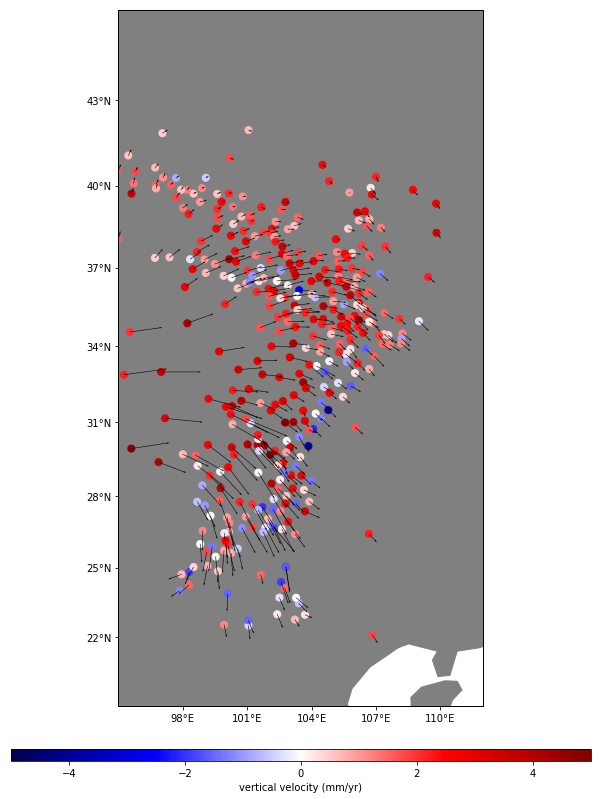

In [6]:
plot_data(data)

In [49]:
blockmean = vd.BlockReduce(np.mean, spacing=2*spacing*111e3, center_coordinates=True)
force_coords = blockmean.filter(proj_coords, np.ones(ndata))[0]
print(force_coords[0].size)

276


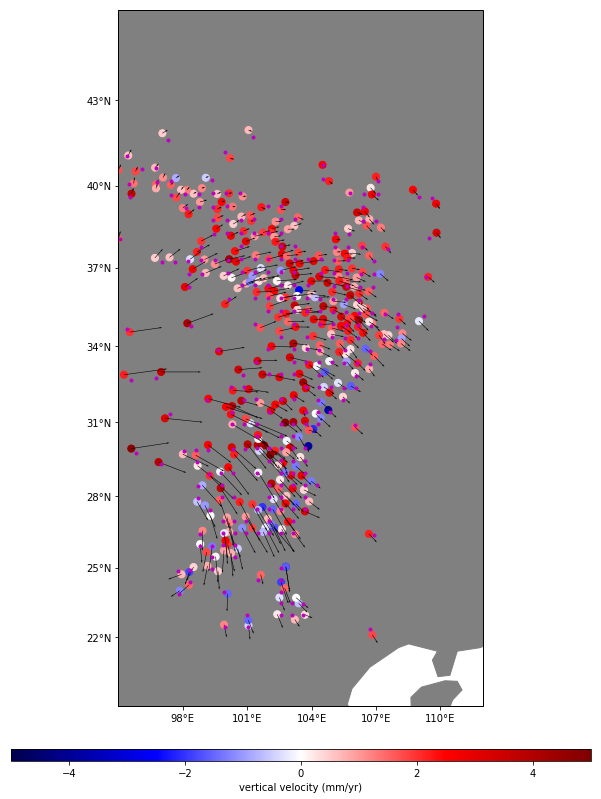

In [50]:
ax = plot_data(data)
ax.plot(*projection(*force_coords, inverse=True), ".m", transform=ccrs.PlateCarree())

In [18]:
%%time
spline = VectorSpline3DCV(
    poissons=[-0.5, -0.25, 0, 0.25, 0.5],
    dampings=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    depths=[10e3, 25e3, 50e3, 100e3, 200e3, 300e3],
    depth_nneighbors=30,
    force_coords=force_coords,
    client=client,
)
spline.fit(proj_coords, components, weights)
print(spline.damping_, spline.depth_, spline.poisson_)
print(spline.score(proj_coords, components, weights))
print(np.mean(vd.cross_val_score(spline.spline_, proj_coords, components, weights=weights)))

0.001 300000.0 -0.5
0.7966964943639248
0.6316200304501091
CPU times: user 8.59 s, sys: 2.05 s, total: 10.6 s
Wall time: 53.6 s


In [51]:
%%time
spline = VectorSpline3D(
    poisson=0.5,
    damping=1e-2,
    depth=200e3, 
    coupling=0.,
    depth_nneighbors=20,
    force_coords=force_coords,
)
spline.fit(proj_coords, components, weights=None)
print(spline.score(proj_coords, components, weights=None))
print(np.mean(vd.cross_val_score(spline, proj_coords, components, weights=None)))

0.8566437898728673
0.5774334398652365
CPU times: user 1.47 s, sys: 655 ms, total: 2.12 s
Wall time: 297 ms


In [52]:
%%time
spline = vd.Vector([
        DummyGridder(), DummyGridder(),
      vd.Spline(damping=1e-4, mindist=500e3, force_coords=force_coords)
])
spline.fit(proj_coords, components)
print(spline.score(proj_coords, components))
print(np.mean(vd.cross_val_score(spline, proj_coords, components)))

-0.5867902708827972
-1.1123494751566507
CPU times: user 161 ms, sys: 288 ms, total: 449 ms
Wall time: 71.6 ms


In [58]:
%%time
spline = vd.Spline(damping=1e-1, mindist=1000e3, force_coords=force_coords)
spline.fit(proj_coords, components[-1])
print(spline.score(proj_coords, components[-1]))
print(np.mean(vd.cross_val_score(spline, proj_coords, components[-1])))

0.4505531907696435
0.18220604515834962
CPU times: user 222 ms, sys: 283 ms, total: 505 ms
Wall time: 87.4 ms


In [61]:
grid = spline.grid(
    region=region,
    spacing=spacing*2, 
    projection=projection,
    dims=["latitude", "longitude"],
    data_names=["up_velocity"]
)
grid = vd.distance_mask(coordinates, maxdist=200e3, grid=grid, projection=projection)

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


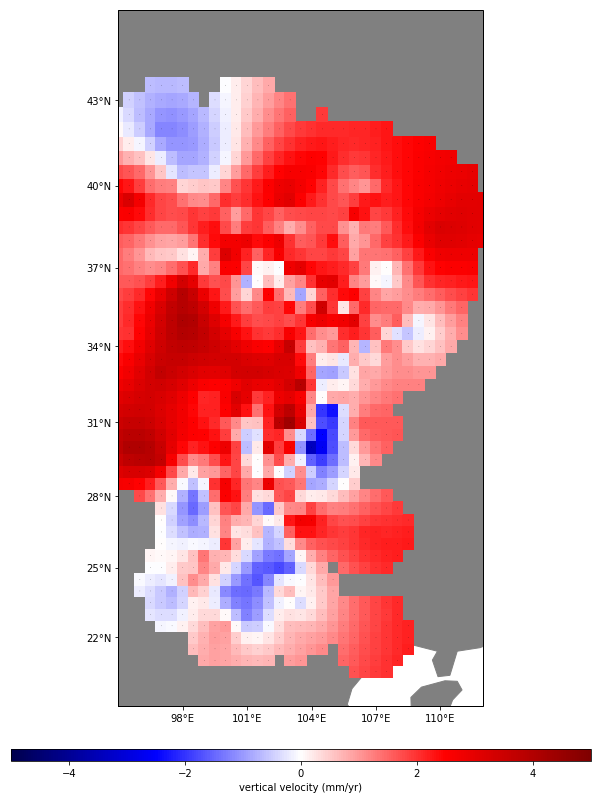

In [60]:
plot_data(grid, every_arrow=1)